In [2]:
# ===================================================================
# PART 0: 라이브러리 임포트
# ===================================================================
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
import joblib

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tcn import TCN

# 한글 폰트 설정
try:
    plt.rc('font', family='AppleGothic')
except:
    plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

print(f"TensorFlow Version: {tf.__version__}")

# ===================================================================
# PART 1: 경로 및 하이퍼파라미터 설정
# ===================================================================
# --- 입력 데이터 경로 ---
IMAGE_DIRECTORY = '../data/interim/satellites'
TABULAR_DATA_PATH = '../data/interim/gang_nam_sendimental_score_with_sale.csv'

# --- 모델 하이퍼파라미터 ---
TIMESTEPS = 12
IMAGE_PCA_COMPONENTS = 32
TABULAR_MLP_COMPONENTS = 64
FUSION_COMPONENTS = 256
BATCH_SIZE = 64
EPOCHS = 50
FORECAST_HORIZON = 12


TensorFlow Version: 2.12.0


In [3]:

# ===================================================================
# PART 2: 데이터 로딩 및 분할
# 모든 전처리 이전에 데이터를 시간순으로 분할하여 데이터 유출(Data Leakage)을 방지합니다.
# ===================================================================
print("\nPART 2: 데이터 로딩 및 분할 시작...")
df = pd.read_csv(TABULAR_DATA_PATH)
df['계약일자'] = pd.to_datetime(df['계약일자'])
df = df.sort_values('계약일자').reset_index(drop=True)
df['image_filename'] = [f'apt_image_{i}.jpg' for i in df.index]
df['image_path'] = df['image_filename'].apply(lambda f: os.path.join(IMAGE_DIRECTORY, f))

# 데이터 분할 (7:2:1 비율)
n_total = len(df)
train_end = int(n_total * 0.7)
val_end = int(n_total * 0.9)
train_df = df[:train_end].copy()
val_df = df[train_end:val_end].copy()
test_df = df[val_end:].copy()
print(f"데이터 분할 완료: Train={len(train_df)}, Validation={len(val_df)}, Test={len(test_df)}")
print("PART 2: 완료!")



PART 2: 데이터 로딩 및 분할 시작...
데이터 분할 완료: Train=15092, Validation=4312, Test=2157
PART 2: 완료!


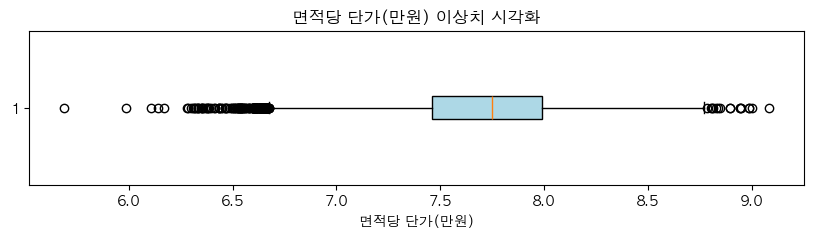

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
plt.boxplot(df["면적당 단가(만원)"], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("면적당 단가(만원) 이상치 시각화")
plt.xlabel("면적당 단가(만원)")
plt.show()

In [5]:

# ===================================================================
# PART 3: 멀티모달 특징 추출 파이프라인
# ===================================================================
print("\nPART 3: 멀티모달 특징 추출 시작...")

# --- 3.1. 이미지 특징 추출 ---
def extract_image_features_2048d(image_paths, batch_size=BATCH_SIZE):
    """ResNet50으로 고차원 특징 벡터를 추출하는 헬퍼 함수"""
    image_input = Input(shape=(224, 224, 3), name='image_input')
    base_cnn = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_tensor=image_input)
    base_cnn.trainable = False
    extractor_model = Model(inputs=image_input, outputs=base_cnn.output, name='resnet50_feature_extractor')
    
    def image_generator(paths, b_size):
        for i in range(0, len(paths), b_size):
            batch_paths = paths[i:i+b_size]
            batch_images = []
            for p in batch_paths:
                try:
                    img = load_img(p, target_size=(224, 224))
                    img_array = img_to_array(img)
                    batch_images.append(img_array)
                except (FileNotFoundError, IOError):
                    batch_images.append(np.zeros((224, 224, 3)))
            yield preprocess_input(np.array(batch_images))
            
    num_batches = int(np.ceil(len(image_paths) / batch_size))
    features = extractor_model.predict(image_generator(image_paths, batch_size), steps=num_batches, verbose=1)
    return features

# 훈련 데이터로 PCA 모델 학습(fit)
print("훈련 데이터로 PCA 모델 학습...")
train_image_features_2048d = extract_image_features_2048d(train_df['image_path'].tolist())
pca = PCA(n_components=IMAGE_PCA_COMPONENTS)
image_vectors = {'train': pca.fit_transform(train_image_features_2048d)}

# 검증 및 테스트 데이터 변환(transform)
print("검증 및 테스트 데이터 변환...")
val_image_features_2048d = extract_image_features_2048d(val_df['image_path'].tolist())
image_vectors['val'] = pca.transform(val_image_features_2048d)
test_image_features_2048d = extract_image_features_2048d(test_df['image_path'].tolist())
image_vectors['test'] = pca.transform(test_image_features_2048d)
print("이미지 특징 추출 완료.")

# --- 3.2. 정형 데이터 특징 추출 ---
tabular_cols = [
    '전용면적(㎡)', '층', '건축년도', '아파트 나이', 'leading_index', '건설기성액(백만원)', 
    '부동산_소비심리지수', '주택시장_소비심리지수', '강남구_변동률', '강남구_누계', 
    '토지시장_소비심리지수', '아파트_호수', '아파트_면적', 'rate'
]
# 훈련 데이터로 스케일러 학습(fit)
tabular_scaler = RobustScaler() # 이상치에 강건한 RobustScaler 사용
train_tabular_scaled = tabular_scaler.fit_transform(train_df[tabular_cols])
# 검증 및 테스트 데이터 변환(transform)
val_tabular_scaled = tabular_scaler.transform(val_df[tabular_cols])
test_tabular_scaled = tabular_scaler.transform(test_df[tabular_cols])

# MLP 특징 추출기 모델 생성
mlp_input = Input(shape=(len(tabular_cols),), name='tabular_input')
embedding_layer = Dense(TABULAR_MLP_COMPONENTS, activation='relu')(mlp_input)
mlp_extractor = Model(inputs=mlp_input, outputs=embedding_layer, name='mlp_feature_extractor')

# 각 데이터셋을 MLP로 변환
tabular_vectors = {
    'train': mlp_extractor.predict(train_tabular_scaled),
    'val': mlp_extractor.predict(val_tabular_scaled),
    'test': mlp_extractor.predict(test_tabular_scaled)
}
print("정형 데이터 특징 추출 완료.")

# --- 3.3. 특징 융합 ---
combined_vectors = {s: np.concatenate([tabular_vectors[s], image_vectors[s]], axis=1) for s in ['train', 'val', 'test']}
fusion_input_dim = combined_vectors['train'].shape[1]
fusion_input = Input(shape=(fusion_input_dim,))
fusion_output = Dense(FUSION_COMPONENTS, activation='relu', name='fusion_layer')(fusion_input)
fusion_model = Model(inputs=fusion_input, outputs=fusion_output, name='fusion_model')
X_final = {s: fusion_model.predict(combined_vectors[s]) for s in ['train', 'val', 'test']}
print(f"최종 융합된 훈련 데이터 형태: {X_final['train'].shape}")
print("PART 3: 완료!")



PART 3: 멀티모달 특징 추출 시작...
훈련 데이터로 PCA 모델 학습...


2025-11-17 12:52:26.620085: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


236/236 [==============================] - 304s 1s/step
검증 및 테스트 데이터 변환...
34/34 [==============================] - 48s 1s/step
이미지 특징 추출 완료.
68/68 [==============================] - 0s 153us/step
정형 데이터 특징 추출 완료.
68/68 [==============================] - 0s 169us/step
최종 융합된 훈련 데이터 형태: (15092, 256)
PART 3: 완료!


In [6]:

# ===================================================================
# PART 4: 타겟 데이터 준비 및 시계열 시퀀스 생성
# ===================================================================
print("\nPART 4: 타겟 데이터 준비 및 시퀀스 생성 시작...")
TARGET_COL = '면적당 단가(만원)'

# 로그 변환 추가 (데이터 분포를 안정화하고, 모델이 상대적 변화에 집중하도록 함)
df[TARGET_COL] = np.log1p(df[TARGET_COL])

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(df.loc[:train_end-1, [TARGET_COL]])
y_val_scaled = scaler_y.transform(df.loc[train_end:val_end-1, [TARGET_COL]])
y_test_scaled = scaler_y.transform(df.loc[val_end:, [TARGET_COL]])

def create_sequences(X_data, y_data, timesteps=TIMESTEPS):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - timesteps):
        X_seq.append(X_data[i:(i + timesteps)])
        y_seq.append(y_data[i + timesteps])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_final['train'], y_train_scaled)
X_val_seq, y_val_seq = create_sequences(X_final['val'], y_val_scaled)
X_test_seq, y_test_seq = create_sequences(X_final['test'], y_test_scaled)
print(f"최종 시퀀스 형태: X_train_seq: {X_train_seq.shape}")
print("PART 4: 완료!")



PART 4: 타겟 데이터 준비 및 시퀀스 생성 시작...
최종 시퀀스 형태: X_train_seq: (15080, 12, 256)
PART 4: 완료!



PART 5: TCN 모델 학습 및 평가 시작...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 32)                39200     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 40,289
Trainable params: 40,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
236/236 [==============================] - 2s 5ms/step - loss: 0.4308 - val_loss: 0.1714
Epoch 2/50
236/236 [==============================] - 1s 6ms/step - loss: 0.1218 - val_loss: 0.1183
Epoch 3/50
236/236 [==============================] - 1s 5ms/step - loss: 0.1119 - val

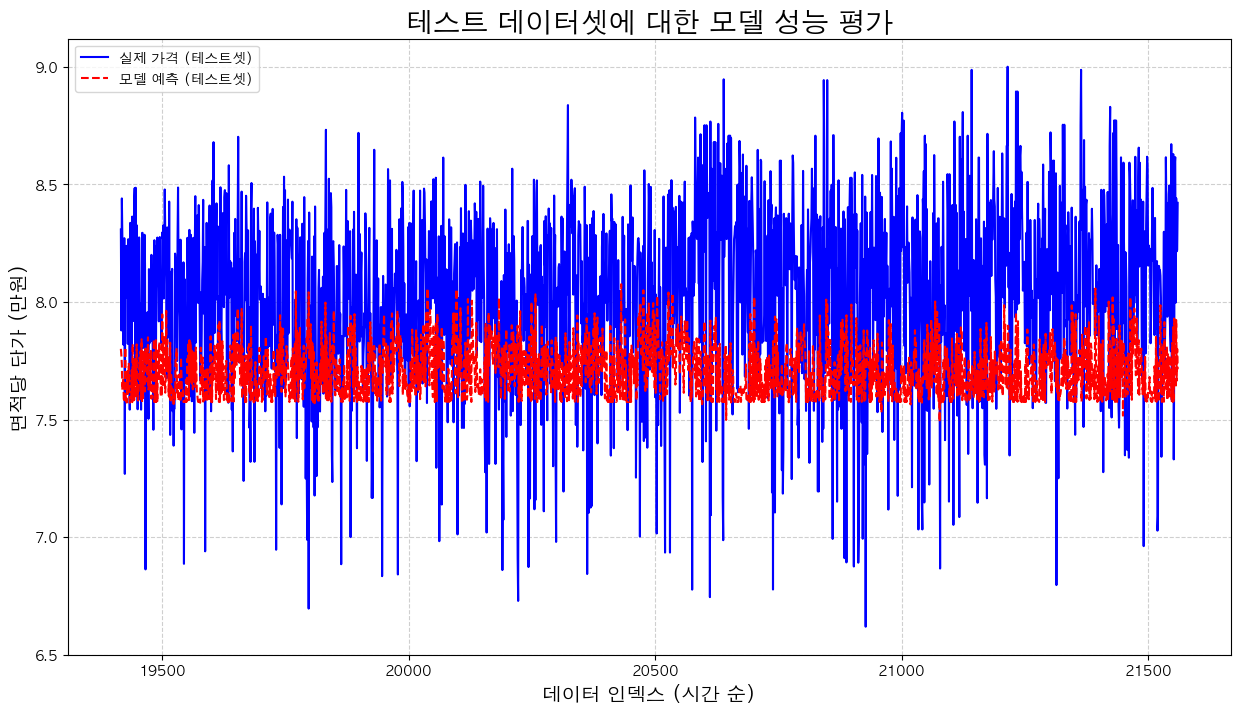

In [7]:

# ===================================================================
# PART 5: TCN 모델 학습 및 평가
# ===================================================================
print("\nPART 5: TCN 모델 학습 및 평가 시작...")
tcn_input_shape = (TIMESTEPS, FUSION_COMPONENTS)
# 과적합 방지를 위해 모델 구조 단순화 및 규제 추가
tcn_model = tf.keras.models.Sequential([
    TCN(input_shape=tcn_input_shape, nb_filters=32, kernel_size=2, dilations=[1, 2, 4, 8],
        use_skip_connections=True, dropout_rate=0.2, return_sequences=False),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])
tcn_model.compile(optimizer='adam', loss='mae')
tcn_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = tcn_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    callbacks=[early_stopping], verbose=1
)

# 모델 평가
y_pred_scaled = tcn_model.predict(X_test_seq)
y_pred_original_log = scaler_y.inverse_transform(y_pred_scaled)
y_test_original_log = scaler_y.inverse_transform(y_test_seq)
# 로그 역변환
y_pred_original = np.expm1(y_pred_original_log)
y_test_original = np.expm1(y_test_original_log)
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f"\n--- 테스트셋 최종 성능 MAE: {mae:.2f} 만원 ---")
print("PART 5: 완료!")


# --- ⬇️ 추가: 테스트 데이터셋에 대한 예측 결과 시각화 ---
print("\nPART 5-1: 테스트셋에 대한 실제값 vs 예측값 시각화...")

# 시각화를 위해 테스트 기간의 실제 날짜 인덱스를 가져옵니다.
test_dates = test_df.iloc[TIMESTEPS:].index

plt.figure(figsize=(15, 8))
plt.plot(test_dates, y_test_original, 'b-', label='실제 가격 (테스트셋)')
plt.plot(test_dates, y_pred_original, 'r--', label='모델 예측 (테스트셋)')
plt.title('테스트 데이터셋에 대한 모델 성능 평가', fontsize=20)
plt.xlabel('데이터 인덱스 (시간 순)', fontsize=14)
plt.ylabel('면적당 단가 (만원)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [8]:

# ===================================================================
# PART 6: 시나리오 기반 미래 예측
# ===================================================================
print("\nPART 6: 시나리오 기반 미래 예측 시작...")

# --- 6.1. 시나리오 변동률 수동 정의 ---
economic_indicators = [
    'leading_index', '건설기성액(백만원)', '부동산_소비심리지수', '주택시장_소비심리지수',
    '강남구_변동률', '강남구_누계', '토지시장_소비심리지수', 'rate'
]
scenarios = {
    '낙관적': {'leading_index': 1.002, '건설기성액(백만원)': 1.001, '부동산_소비심리지수': 1.003, '주택시장_소비심리지수': 1.003, '강남구_변동률': 1.002, '강남구_누계': 1.001, '토지시장_소비심리지수': 1.002, 'rate': 0.999},
    '중립적': {'leading_index': 1.0, '건설기성액(백만원)': 1.0, '부동산_소비심리지수': 1.0, '주택시장_소비심리지수': 1.0, '강남구_변동률': 1.0, '강남구_누계': 1.0, '토지시장_소비심리지수': 1.0, 'rate': 1.0},
    '보수적': {'leading_index': 0.998, '건설기성액(백만원)': 0.999, '부동산_소비심리지수': 0.997, '주택시장_소비심리지수': 0.997, '강남구_변동률': 0.998, '강남구_누계': 0.999, '토지시장_소비심리지수': 0.998, 'rate': 1.001}
}
print("수동으로 설정된 시나리오 변동률:")
print(pd.DataFrame(scenarios).round(4))

# --- 6.2. 재귀적 예측 실행 (효율적 버전) ---
initial_raw_df = df.tail(TIMESTEPS).copy()
# PART 3에서 생성된 최종 특징 벡터의 마지막 부분을 시작점으로 사용
initial_final_features = np.vstack([X_final['val'], X_final['test']])[-TIMESTEPS:]

scenario_predictions_log = {name: [] for name in scenarios.keys()}
current_raw_dfs = {name: initial_raw_df.copy() for name in scenarios.keys()}
current_final_features = {name: initial_final_features.copy() for name in scenarios.keys()}

for i in tqdm(range(FORECAST_HORIZON), desc="미래 예측 중"):
    for name, params in scenarios.items():
        # (1) 현재 시퀀스(최종 특징 벡터)를 바로 모델 입력으로 사용
        input_sequence = np.reshape(current_final_features[name], (1, TIMESTEPS, FUSION_COMPONENTS))
        
        # (2) 모델로 1개월 후 가격 예측 (로그 스케일)
        pred_scaled = tcn_model.predict(input_sequence, verbose=0)
        pred_log = scaler_y.inverse_transform(pred_scaled)[0][0]
        scenario_predictions_log[name].append(pred_log)
        
        # (3) 다음 예측에 사용할 '가상의 미래 데이터' 한 줄 생성 (Raw DF 기준)
        next_raw_row = current_raw_dfs[name].iloc[-1:].copy()
        next_raw_row['계약일자'] += pd.DateOffset(months=1)
        for indicator in economic_indicators:
            next_raw_row[indicator] *= params[indicator]
        next_raw_row[TARGET_COL] = pred_log
        
        # (4) '가상의 미래 데이터' 한 줄만 새로 특징 추출
        next_tabular_scaled = tabular_scaler.transform(next_raw_row[tabular_cols])
        next_tabular_feature = mlp_extractor.predict(next_tabular_scaled, verbose=0)
        
        # 이미지 특징은 마지막 값을 그대로 재사용
        last_image_feature = image_vectors['test'][-1].reshape(1, -1)
        
        next_combined_feature = np.concatenate([next_tabular_feature, last_image_feature], axis=1)
        next_final_feature = fusion_model.predict(next_combined_feature, verbose=0)
        
        # (5) 특징 벡터 시퀀스 업데이트
        updated_features = np.vstack([current_final_features[name][1:], next_final_feature])
        current_final_features[name] = updated_features
        
        # (6) Raw DF 시퀀스도 다음 루프를 위해 업데이트
        updated_df = pd.concat([current_raw_dfs[name].iloc[1:], next_raw_row], ignore_index=True)
        current_raw_dfs[name] = updated_df

print("PART 6: 완료!")



PART 6: 시나리오 기반 미래 예측 시작...
수동으로 설정된 시나리오 변동률:
                 낙관적  중립적    보수적
leading_index  1.002  1.0  0.998
건설기성액(백만원)     1.001  1.0  0.999
부동산_소비심리지수     1.003  1.0  0.997
주택시장_소비심리지수    1.003  1.0  0.997
강남구_변동률        1.002  1.0  0.998
강남구_누계         1.001  1.0  0.999
토지시장_소비심리지수    1.002  1.0  0.998
rate           0.999  1.0  1.001


미래 예측 중: 100%|██████████| 12/12 [00:01<00:00,  6.12it/s]

PART 6: 완료!



PART 7: 최종 결과 출력...

                  시나리오 기반 미래 12개월 매매 가격 예측 (실제 단위)
            낙관적 예측(만원)  중립적 예측(만원)  보수적 예측(만원)
예측 시점                                         
2025-08-01        7.93        7.93        7.93
2025-09-01        7.58        7.58        7.58
2025-10-01        7.64        7.64        7.64
2025-11-01        7.63        7.63        7.63
2025-12-01        7.68        7.68        7.68
2026-01-01        7.60        7.60        7.60
2026-02-01        7.61        7.61        7.61
2026-03-01        7.62        7.63        7.63
2026-04-01        7.59        7.59        7.60
2026-05-01        7.59        7.59        7.60
2026-06-01        7.59        7.59        7.60
2026-07-01        7.59        7.59        7.60


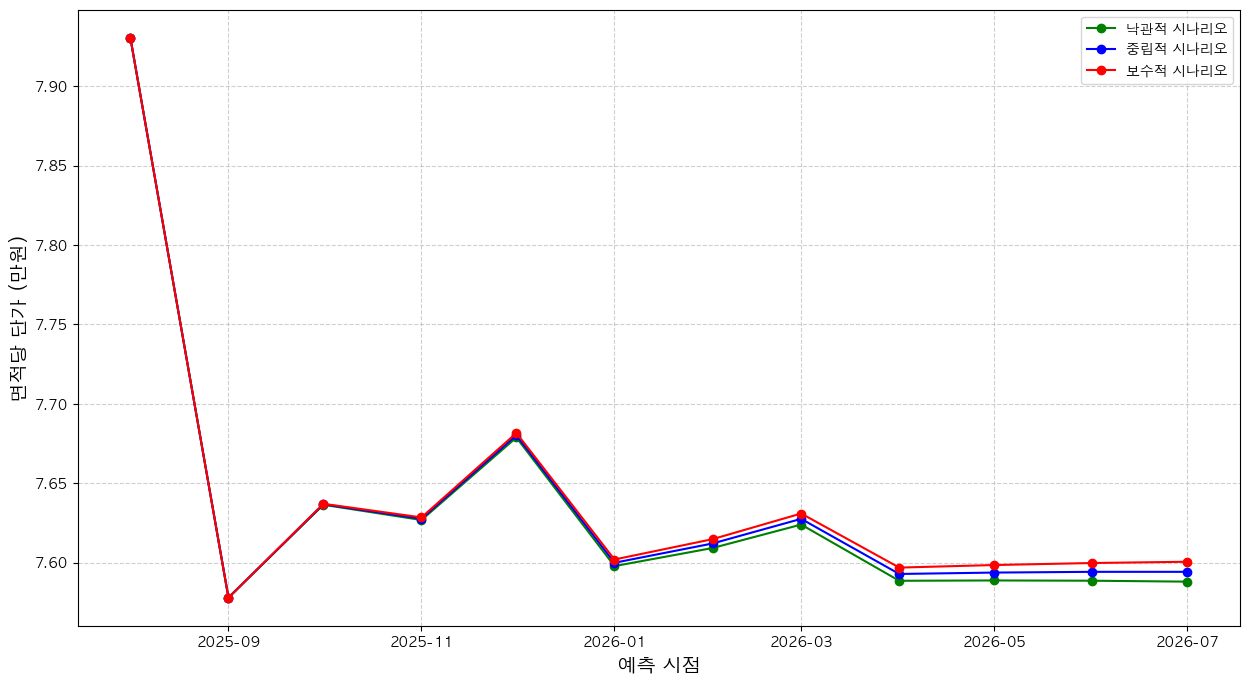


🎉 모든 과정이 성공적으로 완료되었습니다!


In [9]:

# ===================================================================
# PART 7: 최종 결과 출력
# ===================================================================
print("\nPART 7: 최종 결과 출력...")
future_dates = pd.date_range(start=df['계약일자'].max() + pd.DateOffset(months=1), periods=FORECAST_HORIZON, freq='MS')
results_df_log = pd.DataFrame(scenario_predictions_log, index=future_dates)
results_df = np.expm1(results_df_log) # 로그 역변환
results_df = results_df[['낙관적', '중립적', '보수적']]
results_df.columns = ['낙관적 예측(만원)', '중립적 예측(만원)', '보수적 예측(만원)']
results_df.index.name = '예측 시점'

pd.options.display.float_format = '{:,.2f}'.format
print("\n" + "="*75)
print("                  시나리오 기반 미래 12개월 매매 가격 예측 (실제 단위)")
print("="*75)
print(results_df)
print("="*75)

plt.figure(figsize=(15, 8))
plt.plot(results_df['낙관적 예측(만원)'], 'go-', label='낙관적 시나리오')
plt.plot(results_df['중립적 예측(만원)'], 'bo-', label='중립적 시나리오')
plt.plot(results_df['보수적 예측(만원)'], 'ro-', label='보수적 시나리오')
plt.xlabel('예측 시점', fontsize=14)
plt.ylabel('면적당 단가 (만원)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\n🎉 모든 과정이 성공적으로 완료되었습니다!")


# 시나리오 기반 미래 12개월 매매 가격 예측 (자연로그 기준 역변환, 단위: 원)

| 예측 시점   | 낙관적 | 중립적 | 보수적 |
|------------|--------|--------|--------|
| 2025-08-01 | 2,392,000 | 2,392,000 | 2,392,000 |
| 2025-09-01 | 2,469,000 | 2,469,000 | 2,469,000 |
| 2025-10-01 | 2,656,000 | 2,618,000 | 2,618,000 |
| 2025-11-01 | 2,656,000 | 2,656,000 | 2,656,000 |
| 2025-12-01 | 2,618,000 | 2,618,000 | 2,595,000 |
| 2026-01-01 | 2,656,000 | 2,656,000 | 2,618,000 |
| 2026-02-01 | 2,656,000 | 2,618,000 | 2,618,000 |
| 2026-03-01 | 2,656,000 | 2,656,000 | 2,618,000 |
| 2026-04-01 | 2,656,000 | 2,656,000 | 2,618,000 |
| 2026-05-01 | 2,672,000 | 2,656,000 | 2,618,000 |
| 2026-06-01 | 2,672,000 | 2,656,000 | 2,618,000 |
| 2026-07-01 | 2,672,000 | 2,656,000 | 2,618,000 |